Building an email spam detection system

In [1]:
# Import all dependencies
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize


Loading data

In [2]:
mail_data = pd.read_csv('/content/Right spam mail dataset.csv')

Exploratory Data Analysis

In [3]:
mail_data.shape

(5171, 4)

Dataset consists of 5171 rows and 4 columns

In [4]:
print(mail_data.head())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


In [5]:
#drop the unnamed column
mail_data = mail_data.drop('Unnamed: 0', axis=1)
print(mail_data.head())

  label                                               text  label_num
0   ham  Subject: enron methanol ; meter # : 988291\r\n...          0
1   ham  Subject: hpl nom for january 9 , 2001\r\n( see...          0
2   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...          0
3  spam  Subject: photoshop , windows , office . cheap ...          1
4   ham  Subject: re : indian springs\r\nthis deal is t...          0


In [6]:
#class distribution
print(f"\nClass Distribution:")
print(mail_data['label'].value_counts())
print(f"\nClass Percentage:")
print(mail_data['label'].value_counts(normalize=True) * 100)



Class Distribution:
label
ham     3672
spam    1499
Name: count, dtype: int64

Class Percentage:
label
ham     71.01141
spam    28.98859
Name: proportion, dtype: float64


Visualizing the distribution of spam and ham emails

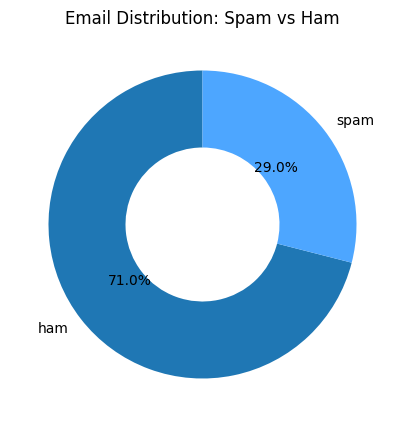

In [7]:
plt.style.use('default')
sns.set_palette("husl")

#getting the class counts of spam and ham (not spam)
# Pie chart version
class_counts = mail_data['label'].value_counts()

#Plot pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    class_counts.values,
    labels=class_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.5),
    colors=['#1f77b4', '#4da6ff']
)
plt.title('Email Distribution: Spam vs Ham')
plt.show()

From the pie chart, its evident that the dataset is imbalanced. It has more ham emails than spam emails


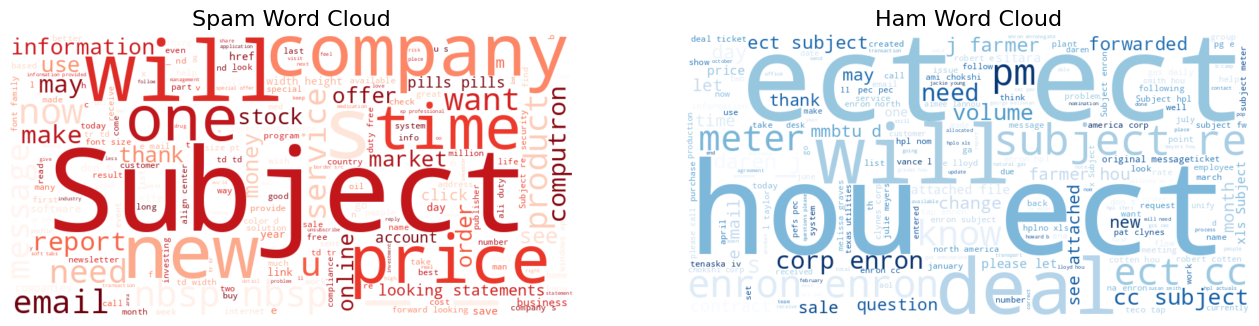

In [8]:

spam_texts = " ".join(mail_data[mail_data['label'] == 'spam']['text'])
ham_texts = " ".join(mail_data[mail_data['label'] == 'ham']['text'])

# Generate word clouds
spam_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_texts)
ham_wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_texts)

#plotting
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Spam Word Cloud", fontsize=16)

plt.subplot(1,2,2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Ham Word Cloud", fontsize=16)

plt.show()


After studying the dataset, these are my finding;
excessive punctuation present,
extra white space visible, presence of URLs
meaningless punctuation present,
stop words present,
random numbers present and
stemming and lemmatization needed.The dataset therefore requires thorough cleaning to reduce noise and enhance text quality, which in turn will improve the performance and reliability of the models.

In [16]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

def advanced_clean_email_text(text):
    # Remove Subject: prefix
    text = re.sub(r'Subject:\s*[^\r\n]*[\r\n]*', '', text, flags=re.IGNORECASE)

    # Remove \r\n and line breaks
    text = re.sub(r'\r\n|\r|\n', ' ', text)

    # Remove email headers and forwarding info
    text = re.sub(r'[-]{4,}.*?forwarded by.*?[-]{4,}', ' ', text, flags=re.IGNORECASE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove numbers (but keep some that might be meaningful)
    # Keep prices like $100, percentages like 30%, but remove random numbers
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    text = re.sub(r'\d{4,}', '', text)   # Remove long number sequences

    # Remove punctuation except some meaningful ones
    text = re.sub(r'[^\w\s$%!?]', ' ', text)

    # Remove excessive punctuation
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Remove single characters and very short words
    tokens = [word for word in tokens if len(word) > 2]

    # Remove remaining punctuation tokens
    tokens = [word for word in tokens if word not in string.punctuation]

    return tokens

# Function with stemming
def clean_with_stemming(text):
    tokens = advanced_clean_email_text(text)

    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join back to text
    return ' '.join(tokens)

# Function with lemmatization
def clean_with_lemmatization(text):
    tokens = advanced_clean_email_text(text)

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back to text
    return ' '.join(tokens)

# Apply different cleaning approaches
print("Applying advanced cleaning...")

# Basic advanced cleaning
mail_data['cleaned_advanced'] = mail_data['text'].apply(lambda x: ' '.join(advanced_clean_email_text(x)))

# With stemming
mail_data['cleaned_stemmed'] = mail_data['text'].apply(clean_with_stemming)

# With lemmatization
mail_data['cleaned_lemmatized'] = mail_data['text'].apply(clean_with_lemmatization)

# Compare the results
print("Comparison of cleaning approaches:")
sample_idx = 2

print(f"\nOriginal:")
print(mail_data['text'].iloc[sample_idx][:200] + "...")

print(f"\nAdvanced Clean:")
print(mail_data['cleaned_advanced'].iloc[sample_idx][:200] + "...")

print(f"\nWith Stemming:")
print(mail_data['cleaned_stemmed'].iloc[sample_idx][:200] + "...")

print(f"\nWith Lemmatization:")
print(mail_data['cleaned_lemmatized'].iloc[sample_idx][:200] + "...")

# Check lengths to see reduction
print(f"\nText length comparison:")
print(f"Original: {len(mail_data['text'].iloc[sample_idx])}")
print(f"Advanced: {len(mail_data['cleaned_advanced'].iloc[sample_idx])}")
print(f"Stemmed: {len(mail_data['cleaned_stemmed'].iloc[sample_idx])}")
print(f"Lemmatized: {len(mail_data['cleaned_lemmatized'].iloc[sample_idx])}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Applying advanced cleaning...
Comparison of cleaning approaches:

Original:
Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to...

Advanced Clean:
around wonderful time year neon leaders retreat time know time year extremely hectic tough think anything past holidays life past week december january like think minute calender handed beginning fall...

With Stemming:
around wonder time year neon leader retreat time know time year extrem hectic tough think anyth past holiday life past week decemb januari like think minut calend hand begin fall semest retreat schedu...

With Lemmatization:
around wonderful time year neon leader retreat time know time year extremely hectic tough think anything past holiday life past week december january like think minute calender handed beginning fall s...

Text length comparison:
Original: 2524
Advanced: 1352
S

In [10]:
# Compare the results
print("Comparison of cleaning approaches:")
sample_idx = 2

print(f"\nOriginal:")
print(mail_data['text'].iloc[sample_idx][:200] + "...")

print(f"\nAdvanced Clean:")
print(mail_data['cleaned_advanced'].iloc[sample_idx][:200] + "...")

print(f"\nWith Stemming:")
print(mail_data['cleaned_stemmed'].iloc[sample_idx][:200] + "...")

print(f"\nWith Lemmatization:")
print(mail_data['cleaned_lemmatized'].iloc[sample_idx][:200] + "...")

# Check lengths to see reduction
print(f"\nText length comparison:")
print(f"Original: {len(mail_data['text'].iloc[sample_idx])}")
print(f"Advanced: {len(mail_data['cleaned_advanced'].iloc[sample_idx])}")
print(f"Stemmed: {len(mail_data['cleaned_stemmed'].iloc[sample_idx])}")
print(f"Lemmatized: {len(mail_data['cleaned_lemmatized'].iloc[sample_idx])}")

Comparison of cleaning approaches:

Original:
Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to...

Advanced Clean:
around wonderful time year neon leaders retreat time know time year extremely hectic tough think anything past holidays life past week december january like think minute calender handed beginning fall...

With Stemming:
around wonder time year neon leader retreat time know time year extrem hectic tough think anyth past holiday life past week decemb januari like think minut calend hand begin fall semest retreat schedu...

With Lemmatization:
around wonderful time year neon leader retreat time know time year extremely hectic tough think anything past holiday life past week december january like think minute calender handed beginning fall s...

Text length comparison:
Original: 2524
Advanced: 1352
Stemmed: 1218
Lemmatized: 1340


Lets Visualize text length comparison

/tmp/ipython-input-2483159171.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=lengths, palette='viridis')


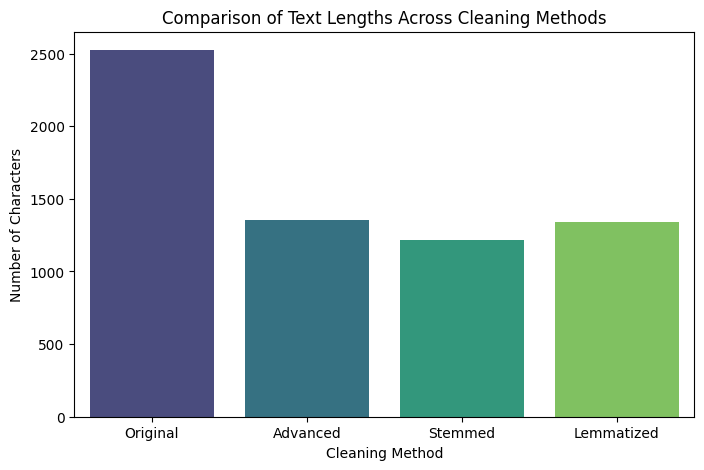

In [17]:
methods = ['Original', 'Advanced', 'Stemmed', 'Lemmatized']
lengths = [
    len(mail_data['text'].iloc[sample_idx]),
    len(mail_data['cleaned_advanced'].iloc[sample_idx]),
    len(mail_data['cleaned_stemmed'].iloc[sample_idx]),
    len(mail_data['cleaned_lemmatized'].iloc[sample_idx])
]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=methods, y=lengths, palette='viridis')
plt.title("Comparison of Text Lengths Across Cleaning Methods")
plt.ylabel("Number of Characters")
plt.xlabel("Cleaning Method")
plt.show()

lemmatization is context aware and produces valid words, therefore the cleaned lemmatized dataset is chosen for model building.

In [11]:
#TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(mail_data['cleaned_lemmatized'])
y = mail_data['label']


In [13]:
#Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, roc_auc_score
)

#build models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'SVM': SVC(class_weight='balanced', probability=True),
    'Random Forest': RandomForestClassifier(class_weight='balanced')
}

#Train and test
results = {}
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test)


    # Results
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='spam')
    recall = recall_score(y_test, y_pred, pos_label='spam')
    f1 = f1_score(y_test, y_pred, pos_label='spam')


    results[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    print(f"{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

#Best model
best_model = max(results, key=lambda x: results[x]['f1'])
print(f"\nBest model: {best_model}")
print(f"F1 score: {results[best_model]['f1']:.4f}")

#Report for best model
best_classifier = models[best_model]
best_classifier.fit(X_train, y_train)
y_pred_best = best_classifier.predict(X_test)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Naive Bayes: Accuracy = 0.9372, Precision = 0.8958, Recall = 0.8805, F1 = 0.8881
Logistic Regression: Accuracy = 0.9527, Precision = 0.8609, Recall = 0.9932, F1 = 0.9223
SVM: Accuracy = 0.9797, Precision = 0.9474, Recall = 0.9829, F1 = 0.9648
Random Forest: Accuracy = 0.9710, Precision = 0.9201, Recall = 0.9829, F1 = 0.9505

Best model: SVM
F1 score: 0.9648

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       742
        spam       0.95      0.98      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



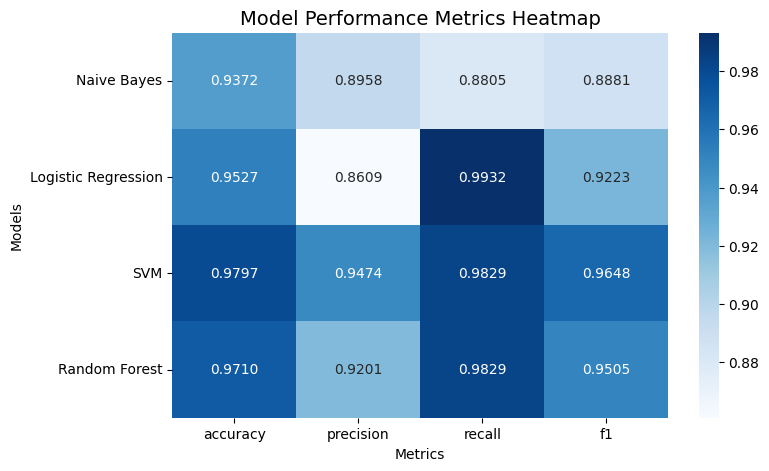

In [15]:
# Convert results dict to DataFrame
results_df = pd.DataFrame(results).T  # Transpose so models are rows


# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="Blues", cbar=True)
plt.title("Model Performance Metrics Heatmap", fontsize=14)
plt.ylabel("Models")
plt.xlabel("Metrics")
plt.show()


The dataset is imbalanced (71% is ham and 29% is spam). In such, accuracy can be misleading, as a model biased toward the majority class may still achieve high accuracy. To mitigate this, much focus is on the F1 score, which is the harmonic mean of precision and recall.
The F1 score therefore provides a balanced evaluation that captures both false positives and false negatives making it more suitable for spam detection tasks.